# Portfolio recommendation

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download historical price data for 4 stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start='2021-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

print(returns.head())


[*********************100%%**********************]  4 of 4 completed

Ticker          AAPL      AMZN     GOOGL      MSFT
Date                                              
2021-01-05  0.012364  0.010004  0.008064  0.000965
2021-01-06 -0.033662 -0.024897 -0.009868 -0.025929
2021-01-07  0.034123  0.007577  0.029869  0.028457
2021-01-08  0.008631  0.006496  0.013239  0.006093
2021-01-11 -0.023249 -0.021519 -0.023106 -0.009698


In [9]:
from arch import arch_model

# Function to fit GARCH(1,1) model and forecast volatility
def garch_volatility_forecast(returns, horizon=5):
    model = arch_model(returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(horizon=horizon)
    return forecast.variance.values[-1, :]

# Forecast volatility for each stock
vol_forecasts = {}
for ticker in tickers:
    vol_forecasts[ticker] = garch_volatility_forecast(returns[ticker])

print("Volatility Forecasts:", vol_forecasts)


Volatility Forecasts: {'AAPL': array([0.00045644, 0.00045485, 0.00045329, 0.00045177, 0.00045027]), 'MSFT': array([0.00037113, 0.00037041, 0.00036971, 0.00036903, 0.00036836]), 'GOOGL': array([0.00044694, 0.00044633, 0.00044573, 0.00044514, 0.00044456]), 'AMZN': array([0.00051494, 0.00051713, 0.00051928, 0.00052138, 0.00052344])}


In [10]:
import scipy.stats as stats

def calculate_var_cvar(returns, alpha=0.05):
    var = np.percentile(returns, alpha * 100)
    cvar = returns[returns <= var].mean()
    return var, cvar

# Calculate VaR and CVaR for each stock
var_cvar = {}
for ticker in tickers:
    var_cvar[ticker] = calculate_var_cvar(returns[ticker])

print("VaR and CVaR:", var_cvar)


VaR and CVaR: {'AAPL': (-0.033190099779703594, -0.040847483914803945), 'MSFT': (-0.029351456843470642, -0.04030803286731683), 'GOOGL': (-0.033006954431352334, -0.043965233190519766), 'AMZN': (-0.03698730142215295, -0.05756125998012648)}


In [16]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download historical price data for the stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start='2021-01-01', end='2022-01-01')['Adj Close']

# Calculate daily returns and statistics
returns = data.pct_change().dropna()
expected_returns = returns.mean() * 250  # Annualized
cov_matrix = returns.cov() * 250  # Annualized
risk_free_rate = 0.03  # Assuming a 3% risk-free rate

# Initialize lists to store portfolio returns, volatilities, and Sharpe ratios
pfolio_returns = []
pfolio_volatilities = []
sharpe_ratios = []
weights_list = []

num_assets = len(tickers)
num_portfolios = 1000


# Monte Carlo simulation to generate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    pfolio_returns.append(portfolio_return)
    pfolio_volatilities.append(portfolio_volatility)
    sharpe_ratios.append(sharpe_ratio)
    weights_list.append(weights)

# Convert lists to numpy arrays
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
sharpe_ratios = np.array(sharpe_ratios)
weights_list = np.array(weights_list)

# Identify the portfolio with the highest Sharpe ratio
max_sharpe_idx = sharpe_ratios.argmax()
optimal_weights = weights_list[max_sharpe_idx]

# Display the results
print("Optimal Weights (Tangency Portfolio):")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"\nPortfolio Return: {pfolio_returns[max_sharpe_idx]:.2%}")
print(f"Portfolio Volatility: {pfolio_volatilities[max_sharpe_idx]:.2%}")
print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_idx]:.2f}")


[*********************100%%**********************]  4 of 4 completed


Optimal Weights (Tangency Portfolio):
AAPL: 0.0235
MSFT: 0.0000
GOOGL: 0.4351
AMZN: 0.5414

Portfolio Return: 49.66%
Portfolio Volatility: 20.65%
Sharpe Ratio: 2.26


In [14]:
portfolios = pd.DataFrame({'Return' : pfolio_returns , 'volatilities' : pfolio_volatilities})

Text(0, 0.5, 'Expected Return')

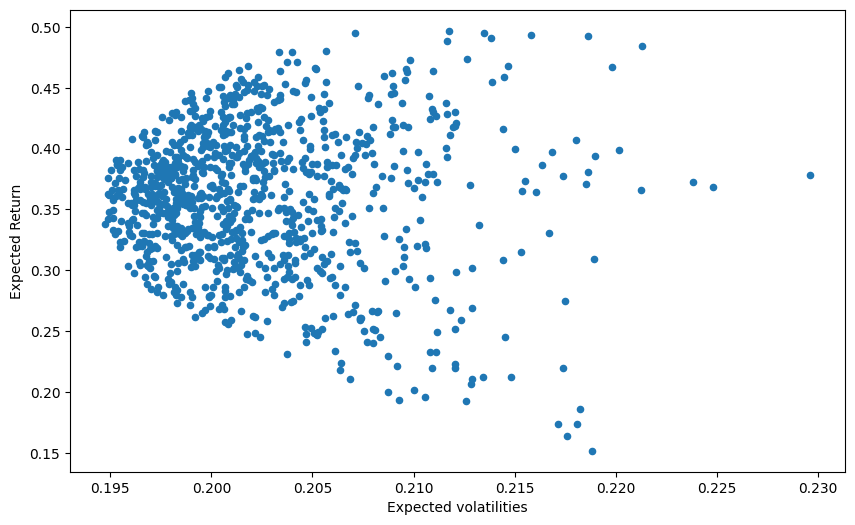

In [15]:
portfolios.plot(x = 'volatilities', y = 'Return' , kind = 'scatter' , figsize = (10, 6))
plt.xlabel('Expected volatilities')
plt.ylabel('Expected Return')